In [1]:
%reload_ext autoreload
%autoreload 2
    
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from matplotlib import pyplot as plt

import tasks
import models

In [20]:
import torch
import snntorch as snn
from snntorch import surrogate


In [26]:
D = 10
lif = snn.Synaptic(beta=torch.rand(D), learn_beta=True, alpha=torch.rand(D), learn_alpha=True)

print("Beta:", lif.beta)
print("Alpha:", lif.alpha)

optimizer = torch.optim.Adam(lif.parameters(), lr=0.01)

v = torch.randn(D)

def increase_output(lif, optimizer):
    mem = torch.zeros(D)
    syn = torch.zeros(D)
    
    total_spikes = torch.zeros(D)
    for _ in range(100):
        spk, syn, mem = lif(v * torch.randn(1), syn=syn, mem=mem)
        total_spikes += spk

    loss = -total_spikes.sum()
    loss.backward()

    optimizer.step()
    return total_spikes

num_epochs = 100
all_spikes = torch.zeros((num_epochs, D))
for epoch in range(num_epochs):
    all_spikes[epoch] = increase_output(lif, optimizer)

print("Beta:", lif.beta)
print("Alpha:", lif.alpha)

Beta: Parameter containing:
tensor([0.2238, 0.2241, 0.5727, 0.5423, 0.6783, 0.0937, 0.2271, 0.2359, 0.9953,
        0.0404], requires_grad=True)
Alpha: Parameter containing:
tensor([0.0253, 0.4761, 0.5927, 0.7459, 0.4165, 0.6207, 0.0409, 0.5735, 0.5026,
        0.8019], requires_grad=True)
Beta: Parameter containing:
tensor([-0.8949, -0.8433,  1.6653,  1.5816, -0.1779, -0.9433, -0.8877,  0.2576,
         1.9757, -0.8238], requires_grad=True)
Alpha: Parameter containing:
tensor([-0.9855, -0.6812,  1.6853,  1.7852, -0.4389, -0.6459, -0.9777,  0.5952,
         1.5140,  0.1396], requires_grad=True)


In [16]:
# Hyperparameters
B = 100 # Batch size
D = 10 # Input dimensions
N = 20 # Number of recurrent neurons
T = 20 # Time steps per trial
sigma = 2.0  # Noise amplitude
learning_rate = 1e-3
num_epochs = 1000
num_contexts = 3

task = tasks.ContextualGoNogo(D, sigma, num_contexts)
start_integration = task.decision_start_time()

# Create network
net = models.SpikingRNN(task.input_dimensionality(), N, 2, beta=2.0, synaptic=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-2)

save_accuracy = torch.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    X, labels, params = task.generate_data(B, T)

    optimizer.zero_grad()
    outputs, spks, mems = net(X, start_integration=start_integration)
    loss = criterion(outputs, labels)  # Use only the last time step for loss
    loss.backward()
    optimizer.step()

    choice = torch.argmax(outputs, dim=1)
    accuracy = torch.sum(choice == labels).item() / B * 100
    save_accuracy[epoch] = accuracy
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')

X, labels, params = task.generate_data(B, T)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)
print(f'Failures: Choice - Labels - EmpiricalS')
errors = torch.stack((choice, labels), dim=1)[choice != labels]
print(errors)
print(f'Accuracy: {torch.sum(choice == labels).item() / B * 100:.2f}%')

Epoch [100/1000], Loss: 0.6877, Accuracy: 58.00%
Epoch [200/1000], Loss: 0.6686, Accuracy: 70.00%
Epoch [300/1000], Loss: 0.6561, Accuracy: 70.00%
Epoch [400/1000], Loss: 0.6294, Accuracy: 79.00%
Epoch [500/1000], Loss: 0.5420, Accuracy: 87.00%
Epoch [600/1000], Loss: 0.5514, Accuracy: 76.00%
Epoch [700/1000], Loss: 0.5315, Accuracy: 77.00%
Epoch [800/1000], Loss: 0.5056, Accuracy: 85.00%
Epoch [900/1000], Loss: 0.5654, Accuracy: 74.00%
Epoch [1000/1000], Loss: 0.5206, Accuracy: 79.00%
Failures: Choice - Labels - EmpiricalS
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]])
Accuracy: 76.00%


In [13]:
net.rnn.beta

Parameter containing:
tensor([2.0883, 2.0370, 2.0350, 2.1592, 2.0962, 2.0224, 2.0857, 2.0478, 2.0688,
        2.0336, 2.0561, 2.0353, 1.9729, 2.1897, 2.0613, 2.0340, 2.1589, 2.1058,
        1.9857, 2.0324], requires_grad=True)

In [5]:
net.rnn.beta

Parameter containing:
tensor(1.0504, requires_grad=True)

torch.Size([20, 20]) torch.Size([20, 20])


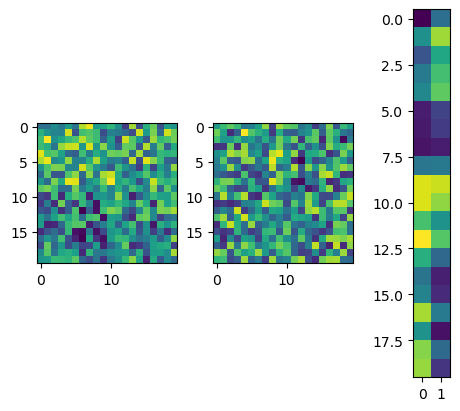

In [17]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)


print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort])
ax[1].imshow(rcweight.T[isort][:, isort])
ax[2].imshow(roweight.T[isort])
plt.show()

In [18]:
params["stimuli"].shape

torch.Size([100, 2])

In [19]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

tensor([[0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 0],
        [1, 1, 1, 0],
        [0, 0, 1, 0],
        [1, 1, 1, 0]])

torch.Size([55, 20]) torch.Size([55, 20]) torch.Size([55, 20])


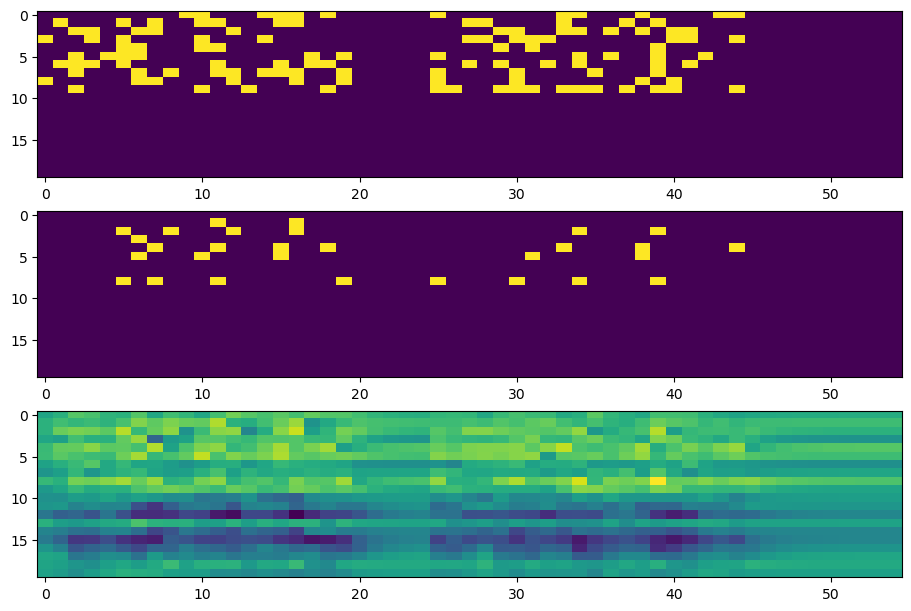

In [23]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()